# Executive summary

This notebook evaluates the discriminative power of geometric features derived from optic disc and cup masks in the ORIGA dataset. While several markers are statistically significant, their substantial overlap limits single-timepoint glaucoma diagnosis. This analysis motivates automated, consistent extraction of geometric features to support diagnosis through longitudinal change rather than isolated measurements.

This notebook:
- extracts geometric features from ORIGA ground-truth masks
- evaluates each feature’s separability (ROC–AUC + statistical tests)
- compares multivariate models (L1 Logistic Regression vs Random Forest)

### Key outputs
- Univariate ROC curves (per feature)
- Cross-validated AUC for LR and RF
- Feature importance summaries


### Data
- ORIGA mask filenames are `001.png`, `002.png`, ...
- `origa_info.csv` contains columns `Image` and `Label` (0=healthy, 1=glaucoma)
- Cup pixels are value 2, disc pixels are >0


## 1. Setup & data paths

In [55]:
import pathlib
import warnings

import numpy as np
import pandas as pd
import cv2
from scipy import ndimage
from scipy.stats import mannwhitneyu, ks_2samp, ttest_ind

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

import matplotlib.pyplot as plt
from IPython.display import display
from tqdm.notebook import tqdm

%matplotlib inline

from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve().parents[1]

mask_dir  = PROJECT_ROOT / "data" / "ORIGA" / "masks"
label_csv = PROJECT_ROOT / "data" / "ORIGA" / "origa_info.csv"

assert mask_dir.exists(), f"Mask dir not found: {mask_dir}"
assert label_csv.exists(), f"Label CSV not found: {label_csv}"

info = pd.read_csv(label_csv)
display(info.head())
print(f"{len(info)} rows")

#configuration
CUP_VALUE = 2


,Image,CDR,Ecc-Cup,Ecc-Disc,Label
0,1,0.7097,0.636027,0.580909,0
1,2,0.6953,0.575024,0.608413,0
2,3,0.9629,0.299303,0.262828,0
3,4,0.7246,0.503186,0.483273,0
4,5,0.6138,0.500141,0.283467,0


650 rows


## 2. Feature engineering from ORIGA masks

In [56]:
def mask_name_from_csv(image_id) -> str:
    """
     ORIGA convention:
     - CSV 'Image' is an integer ID (1..650)
     - masks are named '001.png', '002.png', ... '650.png'
    """
    return f"{int(image_id):03d}.png"



def load_mask(path: pathlib.Path):
    """
    Load ORIGA-style annotation mask and return:
      disc = (mask > 0)
      cup  = (mask == CUP_VALUE)
    """
    m = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if m is None:
        raise FileNotFoundError(f"Mask not found: {path}")
    return (m > 0).astype(np.uint8), (m == CUP_VALUE).astype(np.uint8)


In [57]:
def fit_ellipse_params(mask: np.ndarray):
    """
    Fit an ellipse to the largest contour in a binary mask.

    Returns:
      cx, cy, a, b, ang_rad
    where a,b are semi-axes and ang_rad is ellipse rotation in radians.
    """
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #retr_external to ignore holes inside cup/disc
    #CHAIN_APPROX_NONE to get all contour points
    if not cnts:
        return None
    cnt = max(cnts, key=cv2.contourArea) # if multiple contours, take largest
    if len(cnt) < 5:
        return None # fitEllipse needs at least 5 points

    (cx, cy), (MA, ma), ang = cv2.fitEllipse(cnt)
    #cx, cy = center
    #MA, ma = major and minor axis lengths
    # ang = rotation angle in degrees
    a, b = MA * 0.5, ma * 0.5 # a and b are semi-axes
    return cx, cy, a, b, np.deg2rad(ang)


def radius_along_dir(cx, cy, a, b, ang_rad, dir_xy: np.ndarray) -> float:
    """
    Radius of an ellipse along a direction vector in global coordinates.
    """
    # Rotate direction vector into ellipse-aligned coordinates
    cos_t, sin_t = np.cos(ang_rad), np.sin(ang_rad)
    u_x =  dir_xy[0]*cos_t + dir_xy[1]*sin_t
    u_y = -dir_xy[0]*sin_t + dir_xy[1]*cos_t

    # Ellipse boundary intersection distance along the ray
    denom = (u_x / a)**2 + (u_y / b)**2
    return 1.0 / np.sqrt(denom) if denom > 0 else np.nan


def smallest_positive_root(A, B, C):
    """
    Solve quadratic A t^2 + B t + C = 0 and return smallest positive root.
    """
    disc = B*B - 4*A*C
    if disc <= 0:
        return np.nan
    r1 = (-B - np.sqrt(disc)) / (2*A)
    r2 = (-B + np.sqrt(disc)) / (2*A)
    roots = [r for r in (r1, r2) if r > 0]
    return min(roots) if roots else np.nan


def distance_to_offset_ellipse(src_c, dir_xy, tgt_params):
    """
    Distance from a source point along a direction until intersecting a target ellipse.
    Used to estimate 'cup radius' along the cup-offset direction.
    """
    
    cx, cy, a, b, ang = tgt_params
    cos_t, sin_t = np.cos(ang), np.sin(ang)

    # Translate source point into ellipse-centred coordinates
    vx, vy = src_c[0] - cx, src_c[1] - cy

    # Rotate both position and direction into ellipse-aligned frame
    vx_, vy_ = vx*cos_t + vy*sin_t, -vx*sin_t + vy*cos_t
    dx_, dy_ = dir_xy[0]*cos_t + dir_xy[1]*sin_t, -dir_xy[0]*sin_t + dir_xy[1]*cos_t

    # Quadratic coefficients from substituting ray into ellipse equation
    A = (dx_ / a)**2 + (dy_ / b)**2
    B = 2 * ((vx_ * dx_) / (a*a) + (vy_ * dy_) / (b*b))
    C = (vx_ / a)**2 + (vy_ / b)**2 - 1

    # First forward intersection with ellipse boundary
    return smallest_positive_root(A, B, C)


In [58]:
def cdr_metrics(disc: np.ndarray, cup: np.ndarray) -> dict[str, float]:
    """
    Pixel-based CDR metrics:
      - area_cdr: area(cup) / area(disc)
      - vertical_cdr: vertical extent ratio
      - horizontal_cdr: horizontal extent ratio
    """
    disc_pts = np.column_stack(np.where(disc))
    cup_pts  = np.column_stack(np.where(cup))

    dy_d = np.ptp(disc_pts[:, 0]) if disc_pts.size else 0
    dx_d = np.ptp(disc_pts[:, 1]) if disc_pts.size else 0
    dy_c = np.ptp(cup_pts[:, 0])  if cup_pts.size  else 0
    dx_c = np.ptp(cup_pts[:, 1])  if cup_pts.size  else 0


    return {
        "area_cdr": cup.sum()/disc.sum() if disc.sum() else np.nan,
        "vertical_cdr": dy_c/dy_d if dy_d else np.nan,
        "horizontal_cdr": dx_c/dx_d if dx_d else np.nan,
    }


def isnt_violations(disc, cup):
    """
    Count violations of a simple ISNT rim-area ordering proxy.
    """
    rim = np.logical_and(disc, ~cup)
    h, w = rim.shape
    cy, cx = h//2, w//2

    quad = {
        "I": rim[:cy, cx:],
        "S": rim[:cy, :cx],
        "N": rim[cy:, :cx],
        "T": rim[cy:, cx:]
    }

    order = ["I", "S", "N", "T"]
    cnt = [quad[o].sum() for o in order]
    return sum(cnt[i] < cnt[i+1] for i in range(3))

# Assumption (validated for ORIGA masks): ellipse fitting succeeds for disc and cup
# Otherwise, pixel based methods could be used as fallback.

def rim_to_disc_ratio(disc, cup):
    #as defined in literature, the RDR is defined along the cup-disc offset direction not vertical/horizontal axes
    d_p, c_p = fit_ellipse_params(disc), fit_ellipse_params(cup)
    cx_d, cy_d, a_d, b_d, ang_d = d_p
    cx_c, cy_c, a_c, b_c, ang_c = c_p

    v = np.array([cx_c - cx_d, cy_c - cy_d])
    if np.allclose(v, 0):
        v = np.array([1.0, 0.0])
    n = v / np.linalg.norm(v)

    disc_r = radius_along_dir(cx_d, cy_d, a_d, b_d, ang_d, n)
    cup_r  = distance_to_offset_ellipse((cx_d, cy_d), n, c_p)

    return (disc_r - cup_r) / disc_r if disc_r > cup_r else np.nan


def cup_offset(disc, cup):
    d_p, c_p = fit_ellipse_params(disc), fit_ellipse_params(cup)
    cx_d, cy_d, a_d, b_d, _ = d_p
    cx_c, cy_c, a_c, b_c, _ = c_p

    return np.hypot(cx_c - cx_d, cy_c - cy_d) / np.sqrt(a_d * b_d)


def cup_eccentricity(cup):
    c_p = fit_ellipse_params(cup)
    _, _, a, b, _ = c_p
    return 1 - min(a, b) / max(a, b)


In [59]:
info = pd.read_csv(label_csv).rename(columns=str.lower)

if not {"image", "label"}.issubset(info.columns):
    raise ValueError("CSV must contain columns named Image and Label (case-insensitive).")

print(f"{len(info)} samples found in CSV")

rows = []

for _, row in tqdm(info.iterrows(), total=len(info), desc="Processing masks"):
    fname = mask_name_from_csv(row["image"])
    if not fname:
        continue

    try:
        disc, cup = load_mask(mask_dir / fname)
    except FileNotFoundError:
        warnings.warn(f"Skipping {fname}")
        continue

    m = cdr_metrics(disc, cup)
    m.update({
        "rdr": rim_to_disc_ratio(disc, cup),
        "cup_offset": cup_offset(disc, cup),
        "cup_eccentricity": cup_eccentricity(cup),
        "isnt_violations": isnt_violations(disc, cup),
        "label": row["label"],
        "image": row["image"],
    })


    # Negate RDR so larger values correspond to a more glaucomatous appearance.
    m["rdr_raw"] = m["rdr"]
    m["rdr"] = -m["rdr"]
    rows.append(m)
 
df = pd.DataFrame(rows)
display(df.head())
print("n processed:", len(df))

# Sanity check: ensure no NaNs were introduced by feature computation
feature_cols = [
    "area_cdr",
    "vertical_cdr",
    "horizontal_cdr",
    "rdr",
    "cup_offset",
    "cup_eccentricity",
    "isnt_violations",
]

nan_rows = df[df[feature_cols].isna().any(axis=1)]

if not nan_rows.empty:
    print("NaNs detected in feature computation for the following images:")
    display(nan_rows[["image"] + feature_cols])





650 samples found in CSV


Processing masks:   0%|          | 0/650 [00:00<?, ?it/s]

,area_cdr,vertical_cdr,horizontal_cdr,rdr,cup_offset,cup_eccentricity,isnt_violations,label,image,rdr_raw
0,0.476530,0.709052,0.671958,-0.280837,0.011976,0.228393,1,0.0,1.0,0.280837
1,0.495012,0.694570,0.713068,-0.269590,0.015402,0.181854,1,0.0,2.0,0.269590
2,0.915190,0.962779,0.953728,-0.004584,0.035292,0.045962,1,0.0,3.0,0.004584
3,0.517171,0.723861,0.712538,-0.177900,0.105163,0.136119,1,0.0,4.0,0.177900
4,0.452647,0.612821,0.737968,-0.226220,0.064519,0.134345,1,0.0,5.0,0.226220


n processed: 650


## 3. Univariate evaluation (ROC–AUC + statistical tests)

,metric,mw_p,ks_p,t_p,auc,f
1,vertical_cdr,9.762483e-37,1.236981e-30,5.465303e-37,0.827708,0.827708
0,area_cdr,1.374099e-33,2.005542e-26,5.200629e-30,0.812636,0.812636
3,rdr,1.257056e-28,1.013909e-22,5.024887e-31,0.787307,0.787307
2,horizontal_cdr,6.984534e-23,6.716698e-15,1.065964e-23,0.754909,0.754909
6,isnt_violations,2.325370e-01,6.240323e-01,3.356488e-01,0.523414,0.523414
5,cup_eccentricity,8.411773e-01,8.626130e-01,4.178215e-01,0.494807,0.494807
4,cup_offset,4.060570e-02,1.090414e-01,9.212158e-02,0.446997,0.446997


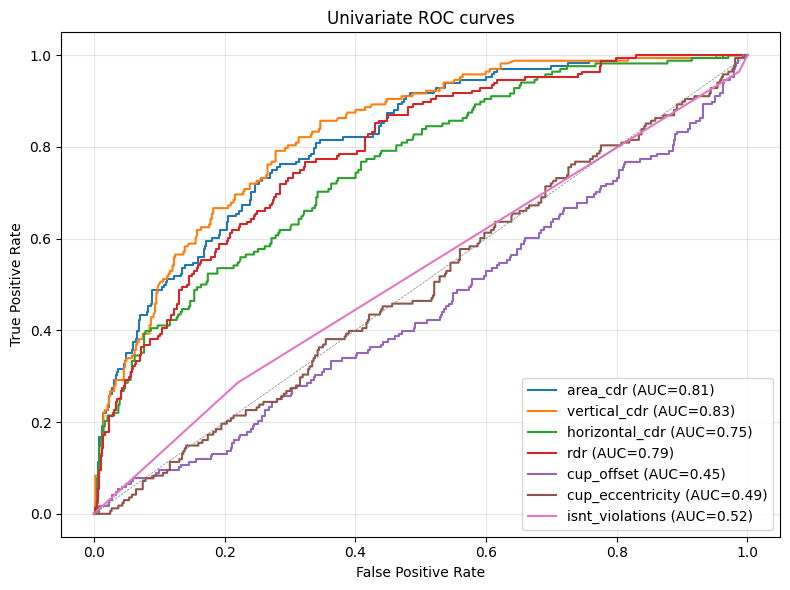

In [60]:
UNI_METRICS = [
    "area_cdr",
    "vertical_cdr",
    "horizontal_cdr",
    "rdr",
    "cup_offset",
    "cup_eccentricity",
    "isnt_violations",
]

stats = []
rocs  = []

for m in UNI_METRICS:
    pos = df[df.label == 1][m].dropna()
    neg = df[df.label == 0][m].dropna()
    if pos.empty or neg.empty:
        continue

    mw_res = mannwhitneyu(pos, neg, alternative="two-sided")
    U_stat, mw_p = mw_res.statistic, mw_res.pvalue

    n1, n0 = len(pos), len(neg)
    f_cl = U_stat / (n1 * n0)

    ks_p = ks_2samp(pos, neg).pvalue
    t_p  = ttest_ind(pos, neg, equal_var=False).pvalue

    scores = df[m].replace([np.inf, -np.inf], np.nan).fillna(0).values
    auc    = roc_auc_score(df.label, scores)
    fpr, tpr, _ = roc_curve(df.label, scores)

    stats.append({"metric": m, "mw_p": mw_p, "ks_p": ks_p, "t_p": t_p, "auc": auc, "f": f_cl})
    rocs.append({"metric": m, "fpr": fpr, "tpr": tpr})

df_stats = pd.DataFrame(stats).sort_values("auc", ascending=False)
display(df_stats)

plt.figure(figsize=(8, 6))
for r in rocs:
    auc_val = df_stats.set_index("metric").loc[r["metric"], "auc"]
    plt.plot(r["fpr"], r["tpr"], label=f"{r['metric']} (AUC={auc_val:.2f})")
plt.plot([0, 1], [0, 1], "--", lw=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Univariate ROC curves")
plt.legend()
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()


### Conclusion

Although several geometric markers exhibit statistically significant differences between healthy and glaucomatous eyes (Mann–Whitney U, KS, and Welch’s t-tests), the observed effect sizes indicate substantial overlap between class distributions. This confirms that statistical significance alone does not imply strong discriminative power.

The ROC analysis confirms that vertical CDR provides the strongest univariate discrimination, while other markers such as rim-to-disc ratio perform less effectively on ORIGA than reported in prior literature. Importantly, all ROC curves exhibit gradual slopes rather than sharp transitions, highlighting that no single geometric marker can perfectly separate healthy and glaucomatous eyes. 

## 4. Multivariate modelling (cross-validated AUC)

In [61]:
FEATURES = UNI_METRICS
X = df[FEATURES].values
y = df.label.astype(int).values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_auc(pipe):
    scores = []
    for tr, te in skf.split(X, y):
        pipe.fit(X[tr], y[tr])
        scores.append(roc_auc_score(y[te], pipe.predict_proba(X[te])[:, 1]))
    return np.mean(scores)

rf = make_pipeline(
    SimpleImputer(strategy="median"),
    SelectFromModel(RandomForestClassifier(n_estimators=500, random_state=42), threshold="median"),
    RandomForestClassifier(n_estimators=300, random_state=0),
)

lr = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    LogisticRegression(penalty="l1", C=0.3, solver="saga", max_iter=4000),
)

model_df = pd.DataFrame([
    {"model": "RandomForest", "auc": cv_auc(rf)},
    {"model": "LogisticReg", "auc": cv_auc(lr)},
])
display(model_df)


,model,auc
0,RandomForest,0.793499
1,LogisticReg,0.824366


In [62]:
lr.fit(X, y)
coef = lr.named_steps["logisticregression"].coef_[0]
coef_series = pd.Series(coef, index=FEATURES)
nonzero = coef_series[coef_series != 0].round(4)
nonzero = nonzero.sort_values(ascending=False)
print("Logistic Regression non-zero coefficients:")
display(nonzero)

rf.fit(X, y)

selector = rf.named_steps["selectfrommodel"]
kept_idx = selector.get_support(indices=True)
kept_names = [FEATURES[i] for i in kept_idx]

imp = rf.named_steps["randomforestclassifier"].feature_importances_
fi = pd.Series(imp, index=kept_names).sort_values(ascending=False)
print("Random Forest feature importances:")
display(fi)



Logistic Regression non-zero coefficients:


vertical_cdr        1.3694
isnt_violations     0.1594
rdr                 0.1184
cup_offset          0.0044
cup_eccentricity   -0.0874
dtype: float64

Random Forest feature importances:


vertical_cdr      0.318123
area_cdr          0.279913
rdr               0.213503
horizontal_cdr    0.188462
dtype: float64

### Conclusion

Despite combining multiple geometric markers, both the logistic regression and random forest models fail to outperform the best univariate metric (vertical CDR). This suggests that much of the discriminative information is shared between features, and that multivariate models primarily repackage existing information rather than uncovering new separability.

# Final Conclusion



This analysis demonstrates that glaucoma diagnosis from fundus images is fundamentally constrained by the limited discriminative power of geometric markers such as cup-to-disc ratio, rim-to-disc ratio, and related shape-based features. While several of these markers exhibit statistically significant differences between healthy and glaucomatous eyes, substantial overlap in their distributions limits their standalone diagnostic performance.

As a consequence, the accuracy of a segmentation-based pipeline for glaucoma diagnosis is inherently bounded by the information content of these geometric features, rather than by the segmentation model itself. In this context, improving segmentation accuracy alone cannot fully overcome the intrinsic diagnostic ceiling imposed by fundus-derived geometry.

Despite these limitations, vertical cup-to-disc ratio remains a clinically accepted marker, particularly because significant changes in its value over time are themselves indicative of glaucomatous progression and are used as diagnostic evidence. Accurate and consistent measurement is therefore critical, even when single-timepoint discrimination is limited.

The pipeline developed in this work addresses a key practical barrier by automating the extraction of clinically relevant geometric measurements from fundus images, enabling consistent, scalable, and reproducible analysis. Rather than replacing clinical judgment, this system lowers the barrier to longitudinal assessment and large-scale screening, supporting diagnosis through change detection as well as disease monitoring.
